In [20]:
import colorsys
import imghdr
import os
import random

import numpy as np
from keras import backend as K
from keras.models import load_model
from PIL import Image, ImageDraw, ImageFont

import numpy as np
import tensorflow as tf
from keras.layers import Lambda
from keras.layers.merge import concatenate

from moviepy.editor import VideoFileClip
from scipy import misc

In [21]:
model_path = '../model/yolo.h5'
anchors_path = '../model/yolo_anchors.txt'
classes_path = '../model/coco_classes.txt'
data_path = '../data/'
output_path = '../output/'

In [22]:
sess = K.get_session()# TODO: Remove dependence on Tensorflow session.

In [23]:
with open(classes_path) as f:
    class_names = f.readlines()
class_names = [c.strip() for c in class_names]

with open(anchors_path) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)

In [24]:
yolo_model = load_model(model_path)

In [25]:
yolo_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 608, 608, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 608, 608, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 608, 608, 32)  128         conv2d_1[0][0]                   
____________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)        (None, 608, 608, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [26]:
num_classes = len(class_names)
num_anchors = len(anchors)

In [27]:
# TODO: Assumes dim ordering is channel last
model_output_channels = yolo_model.layers[-1].output_shape
print (model_output_channels)
print('{} model, anchors, and classes loaded.'.format(model_path))

(None, 19, 19, 425)
../model/yolo.h5 model, anchors, and classes loaded.


In [28]:
# Check if model is fully convolutional, assuming channel last order.
model_image_size = yolo_model.layers[0].input_shape[1:3]
is_fixed_size = model_image_size != (None, None)
print(model_image_size)

(608, 608)


In [29]:
# Generate colors for drawing bounding boxes.
hsv_tuples = [(x / len(class_names), 1., 1.)
              for x in range(len(class_names))]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(
    map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
        colors))
random.seed(10101)  # Fixed seed for consistent colors across runs.
random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
random.seed(None)  # Reset seed to default.

In [30]:
def yolo_head(feats, anchors, num_classes):
    """Convert final layer features to bounding box parameters.

    Parameters
    ----------
    feats : tensor
        Final convolutional layer features.
    anchors : array-like
        Anchor box widths and heights.
    num_classes : int
        Number of target classes.

    Returns
    -------
    box_xy : tensor
        x, y box predictions adjusted by spatial location in conv layer.
    box_wh : tensor
        w, h box predictions adjusted by anchors and conv spatial resolution.
    box_conf : tensor
        Probability estimate for whether each box contains any object.
    box_class_pred : tensor
        Probability distribution estimate for each box over class labels.
    """
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])

    # Static implementation for fixed models.
    # TODO: Remove or add option for static implementation.
    # _, conv_height, conv_width, _ = K.int_shape(feats)
    # conv_dims = K.variable([conv_width, conv_height])

    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    # Static generation of conv_index:
    # conv_index = np.array([_ for _ in np.ndindex(conv_width, conv_height)])
    # conv_index = conv_index[:, [1, 0]]  # swap columns for YOLO ordering.
    # conv_index = K.variable(
    #     conv_index.reshape(1, conv_height, conv_width, 1, 2))
    # feats = Reshape(
    #     (conv_dims[0], conv_dims[1], num_anchors, num_classes + 5))(feats)

    box_xy = K.sigmoid(feats[..., :2])
    box_wh = K.exp(feats[..., 2:4])
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.softmax(feats[..., 5:])

    # Adjust preditions to each spatial grid point and anchor size.
    # Note: YOLO iterates over height index before width index.
    box_xy = (box_xy + conv_index) / conv_dims
    box_wh = box_wh * anchors_tensor / conv_dims

    return box_xy, box_wh, box_confidence, box_class_probs

In [31]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return K.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])

In [32]:
def yolo_eval(yolo_outputs,
              image_shape,
              max_boxes=10,
              score_threshold=.6,
              iou_threshold=.5):
    """Evaluate YOLO model on given input batch and return filtered boxes."""
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    boxes, scores, classes = yolo_filter_boxes(
        boxes, box_confidence, box_class_probs, threshold=score_threshold)

    # Scale boxes back to original image shape.
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims

    # TODO: Something must be done about this ugly hack!
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    nms_index = tf.image.non_max_suppression(
        boxes, scores, max_boxes_tensor, iou_threshold=iou_threshold)
    boxes = K.gather(boxes, nms_index)
    scores = K.gather(scores, nms_index)
    classes = K.gather(classes, nms_index)
    return boxes, scores, classes

In [33]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold=.6):
    """Filter YOLO boxes based on object and class confidence."""
    box_scores = box_confidence * box_class_probs
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)
    prediction_mask = box_class_scores >= threshold

    # TODO: Expose tf.boolean_mask to Keras backend?
    boxes = tf.boolean_mask(boxes, prediction_mask)
    scores = tf.boolean_mask(box_class_scores, prediction_mask)
    classes = tf.boolean_mask(box_classes, prediction_mask)
    return boxes, scores, classes


In [34]:
#################################change to tune the output
score_threshold=.3
iou_threshold=.5
# Generate output tensor targets for filtered bounding boxes.
# TODO: Wrap these backend operations with Keras layers.
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes = yolo_eval(
    yolo_outputs,
    input_image_shape,
    score_threshold=score_threshold,
    iou_threshold=iou_threshold)

In [35]:
wanted_classes=['bicycle','car','truck','person','bus','motorbike']

In [36]:
def frame_func_left(image):
    image=image[:,:608,:]    
    image_data=np.array(image, dtype='float32')
    image = Image.fromarray(image)
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    out_boxes, out_scores, out_classes = sess.run(
        [boxes, scores, classes],
        feed_dict={
            yolo_model.input: image_data,
            input_image_shape: [image.size[1], image.size[0]],
            K.learning_phase(): 0
        })

    font = ImageFont.truetype(
        font='../font/FiraMono-Medium.otf',
        size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300
    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        if predicted_class not in wanted_classes:
            continue
        box = out_boxes[i]
        score = out_scores[i]
        
        label = '{} {:.2f}'.format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
#         print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw
    image=np.array(image)    
    return image

In [24]:
for count, file in enumerate(os.listdir('../data/camera_left')):
    project_video_output=os.path.join(output_path,str(count)+'left.mp4')
    clip1= VideoFileClip(os.path.join(data_path+'/camera_left',file)).subclip(0,60)
    clip2= clip1.resize(height=608)
    lane_clip = clip2.fl_image(frame_func_left) #NOTE: this function expects color images!!
    %time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ../output/0left.mp4
[MoviePy] Writing video ../output/0left.mp4


100%|█████████▉| 1380/1381 [02:33<00:00,  8.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/0left.mp4 

CPU times: user 7min 49s, sys: 24.5 s, total: 8min 13s
Wall time: 2min 33s
[MoviePy] >>>> Building video ../output/1left.mp4
[MoviePy] Writing video ../output/1left.mp4


100%|█████████▉| 840/841 [01:47<00:00,  7.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/1left.mp4 

CPU times: user 5min 30s, sys: 18 s, total: 5min 48s
Wall time: 1min 48s
[MoviePy] >>>> Building video ../output/2left.mp4
[MoviePy] Writing video ../output/2left.mp4


100%|█████████▉| 600/601 [01:21<00:00,  7.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/2left.mp4 

CPU times: user 4min 6s, sys: 13.6 s, total: 4min 19s
Wall time: 1min 21s


In [55]:
project_video_output = '../output/sample.mp4'
clip1 = VideoFileClip("../data/ip10_108_430_435_pm.MP4").subclip(0,60)
clip2=clip1.resize(height=608)

In [56]:
lane_clip = clip2.fl_image(frame_func) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)

OSError: cannot open resource

In [41]:
def frame_func_right(image):
    image=image[:,-608:,:]
    
    image_data=np.array(image, dtype='float32')
    image = Image.fromarray(image)
    
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    out_boxes, out_scores, out_classes = sess.run(
        [boxes, scores, classes],
        feed_dict={
            yolo_model.input: image_data,
            input_image_shape: [image.size[1], image.size[0]],
            K.learning_phase(): 0
        })

    font = ImageFont.truetype(
        font='../font/FiraMono-Medium.otf',
        size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300
    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        if predicted_class not in wanted_classes:
            continue
        box = out_boxes[i]
        score = out_scores[i]
        
        label = '{} {:.2f}'.format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
#         print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw
    image=np.array(image)    
    return image

In [42]:
for count, file in enumerate(os.listdir('../data/camera_right')):
    project_video_output=os.path.join(output_path,str(count)+'right.mp4')
    clip1= VideoFileClip(os.path.join(data_path+'/camera_right',file)).subclip(0,60)
    clip2= clip1.resize(height=608)
    lane_clip = clip2.fl_image(frame_func_right) #NOTE: this function expects color images!!
    %time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ../output/0right.mp4
[MoviePy] Writing video ../output/0right.mp4


100%|█████████▉| 1380/1381 [02:22<00:00,  9.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/0right.mp4 

CPU times: user 7min 14s, sys: 22.4 s, total: 7min 37s
Wall time: 2min 22s
[MoviePy] >>>> Building video ../output/1right.mp4
[MoviePy] Writing video ../output/1right.mp4


100%|█████████▉| 1380/1381 [02:30<00:00,  9.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/1right.mp4 

CPU times: user 7min 35s, sys: 24.5 s, total: 8min
Wall time: 2min 30s
[MoviePy] >>>> Building video ../output/2right.mp4
[MoviePy] Writing video ../output/2right.mp4


100%|█████████▉| 780/781 [01:26<00:00,  8.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/2right.mp4 

CPU times: user 4min 21s, sys: 14 s, total: 4min 35s
Wall time: 1min 26s


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 0: invalid start byte

In [13]:
image=Image.open('dog.jpg')

In [14]:
image=np.array(image)

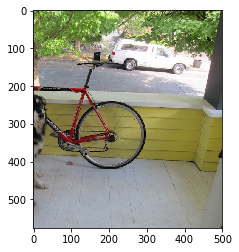

In [18]:
from matplotlib import pyplot as plt
plt.imshow(image[:,-500:,:])